<a href="https://colab.research.google.com/github/1Rohan20/first/blob/main/DBSCAN_FOR_WALMART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

In [ ]:
customer_data = pd.read_csv('/content/walmart_reduced.csv')
customer_data.dropna(inplace=True)
customer_data.drop_duplicates(inplace=True)

In [ ]:
for col in customer_data.columns:
    if customer_data[col].dtype == 'object':
        customer_data[col] = LabelEncoder().fit_transform(customer_data[col])

In [ ]:
X = customer_data.iloc[:, [4, 8, 9]].values
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


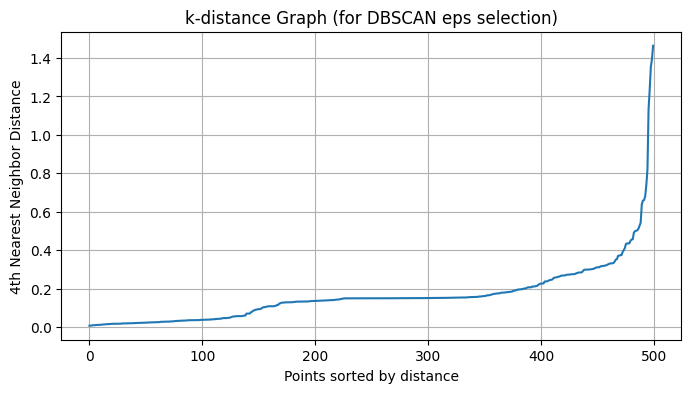

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('k-distance Graph (for DBSCAN eps selection)')
plt.xlabel('Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.grid(True)
plt.show()


Best eps: 0.30 with silhouette score: 0.2935


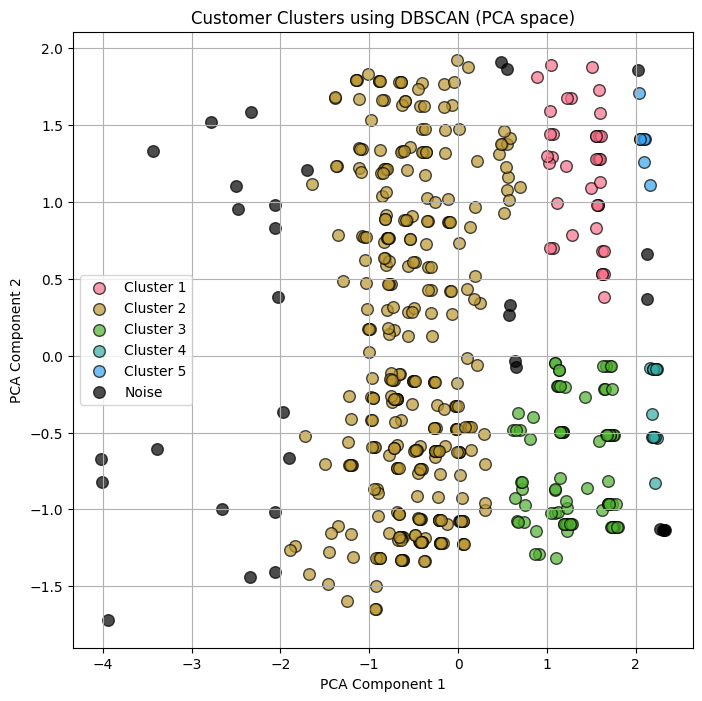

In [ ]:
best_eps = 0
best_score = -1
best_labels = None
eps_range = np.arange(0.2, 2.0, 0.1)

for eps in eps_range:
    db = DBSCAN(eps=eps, min_samples=5).fit(X_pca)
    labels = db.labels_

    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)

    if len(unique_labels) > 1 and (labels != -1).sum() > 0:
        score = silhouette_score(X_pca[labels != -1], labels[labels != -1])
        if score > best_score:
            best_score = score
            best_eps = eps
            best_labels = labels

if best_labels is not None:
    print(f'Best eps: {best_eps:.2f} with silhouette score: {best_score:.4f}')
    dbscan = DBSCAN(eps=best_eps, min_samples=5)
    Y = dbscan.fit_predict(X_pca)

    plt.figure(figsize=(8, 8))
    unique_labels = set(Y)
    colors = sns.color_palette("husl", len(unique_labels))

    for label in unique_labels:
        color = 'k' if label == -1 else colors[label % len(colors)]
        label_name = 'Noise' if label == -1 else f'Cluster {label + 1}'
        plt.scatter(X_pca[Y == label, 0], X_pca[Y == label, 1], s=70, c=[color], label=label_name, edgecolors='black', alpha=0.7)

    plt.title('Customer Clusters using DBSCAN (PCA space)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
    # Evaluate
    sil_score = silhouette_score(X_pca[Y != -1], Y[Y != -1])
    db_score = davies_bouldin_score(X_pca[Y != -1], Y[Y != -1])
    print(f'Silhouette Score: {sil_score:.4f}')
    print(f'Davies-Bouldin Score: {db_score:.4f}')

Silhouette Score: 0.2935
Davies-Bouldin Score: 0.7716
